# The Deutsch-Josza Algorithm
The Deutsch-Josza algorithm is useful in solving the Deutsch's problem described as follows:
Alice selects a number $x$ from $0$ to $2^n-1$ and sends it to Bob who calculates $f(x)$ and sends it back to Alice. The function $f(x)$ attains either the value 0 or 1 for each $x$ and satisfies either one of the following two properties:
1. $f(x)$ is *constant* for all values of $x$.
2. $f(x)$ is *balanced*, i,e., it attains the value 0 for exactly half of all possible $x$ and 1 for the other half.

Alice's job is to determine whether the function is constant or balanced. In the classical situation, where Alice sends n bits to represent her number each time, at worst it would take $\frac{2^n}{2}+1$ trials for Alice to determine, since a function could attain the same value for the first half of trials and the next trial could still give a different value, if it were balanced.


If Alice and Bob use qubits, and Bob uses the unitary operator $U_f$ to calculate $f(x)$ then Alice's number is stored in the $n$ qubit query register and Bob uses the single qubit answer register to store the result of his operator. Alice then follows the described algorithm to carry out the task.

<img src="https://raw.githubusercontent.com/mnp-club/Quantum_Computing_Workshop_2020/master/images/jozsa.jpg" width=500 height=400> </img>

The input state is $$\vert \psi_0 \rangle = \vert 0 \rangle^{\otimes n}\vert 1\rangle.$$
After applying the Hadamard transform on all the qubits, the state is:
\begin{align*}
\vert \psi_1 \rangle &=\left(\frac{\vert 0 \rangle + \vert 1 \rangle}{\sqrt{2}}\right)^{\otimes n}\left(\frac{\vert 0 \rangle -\vert 1\rangle}{\sqrt{2}}\right)\\
&=\sum\limits_{x\in\{0,1\}^n}\frac{\vert x \rangle}{\sqrt{2^n}}\left(\frac{\vert 0 \rangle -\vert 1\rangle}{\sqrt{2}}\right)
\end{align*}
If we apply $U_f$ gate to state $\vert x \rangle \left( \frac{\vert 0\rangle - \vert 1\rangle}{\sqrt{2}}\right)$, we get the following state
 
\begin{align*}
\vert x \rangle\left(\frac{\vert f(x)\rangle -\vert 1\oplus f(x)\rangle}{\sqrt{2}}\right)
&=\begin{cases}
		\vert x \rangle\left(\frac{\vert 0\rangle -\vert 1\rangle}{\sqrt{2}}\right) & \text{if $f(x)=0$}\\
		\vert x \rangle\left(\frac{\vert 1\rangle -\vert 0\rangle}{\sqrt{2}}\right) & \text{if $f(x)=1$}\\
	\end{cases}\\
&=(-1)^{f(x)}\vert x \rangle \left(\frac{\vert 0\rangle -\vert 1\rangle}{\sqrt{2}}\right)
\end{align*} So, on applying $U_f$ to $\vert \psi_1 \rangle$, we get:
$$\vert \psi_2 \rangle=\sum\limits_{x}\frac{(-1)^{f(x)}\vert x \rangle}{\sqrt{2^n}}\left(\frac{\vert 0 \rangle -\vert 1\rangle}{\sqrt{2}}\right).$$
For a single qubit $\vert x \rangle,$ $$H\vert x \rangle=\sum\limits_{z}\frac{(-1)^{xz}\vert z \rangle}{\sqrt{2}}.$$
For $n$ qubits $$H^{\otimes n}\vert x_1,...x_n \rangle=\sum\limits_{z_1,...z_n}\frac{(-1)^{x_1z_1+...x_nz_n}\vert z_1,...z_n \rangle}{\sqrt{2^n}}$$
i.e., $$H^{\otimes n}\vert x \rangle=\sum\limits_{z}\frac{(-1)^{x\cdot z}\vert z \rangle}{\sqrt{2^n}}$$ where $x\cdot z$ represents the bitwise inner product of $x$ and $z$, modulo 2.

Applying Hadamard transform on the query register, we obtain
$$\vert \psi_3 \rangle=\sum\limits_z\sum\limits_{x}\frac{(-1)^{x.z+f(x)}\vert z \rangle}{2^n}\left(\frac{\vert 0 \rangle -\vert 1\rangle}{\sqrt{2}}\right).$$

The amplitude for the state $\vert 0 \rangle^{\otimes n}$ is $\displaystyle{\sum\limits_{x}\frac{(-1)^{f(x)}}{2^n}}$.

If $f$ is constant, the amplitude will be $\pm 1$, which means all other amplitudes will be 0, so an observation will yield 0s for all qubits in the query register. If $f$ is balanced, then the positive and negative contributions to the amplitude of the state $\vert 0 \rangle^{\otimes n}$ cancel, leaving an amplitude of 0, and a measurement must yield a result other than 0 on at least one qubit in the query register.

Therefore, if on measuring the query register, Alice obtains all 0s  then the function is constant; otherwise the function is balanced. 

Hence, a quantum computer can solve Deutsch’s problem with one evaluation of the function $f$ compared to the classical requirement for $\frac{2^n}{2}+1$ evaluations.

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
from fractions import Fraction as frac 
import qiskit.quantum_info as qi
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

## Creating Quantum Oracles
Now, we will attempt to construct a circuit in order to demonstrate the above algorithm for a particular case. Before that let's have a look at the internal circuitry of the quantum oracles $U_f$ used to calculate $f(x)$.

For a constant function, it is simple:

  1. if $f(x)$ = 0, then $\vert y \oplus f(x)\rangle = \vert y\rangle$ so apply the  $I$  gate to the qubit in register 2 (i.e., no need to apply any gates).
  2. if $f(x)$ = 1, then $\vert y \oplus f(x)\rangle = \vert y \oplus 1\rangle$ so apply the  $X$  gate to the qubit in register 2.
  
A simple way to create a balanced function is by applying the CNOT gate for each qubit in register 1, with the qubit in register 2 as the target. Shown below is an example of a quantum oracle for a balanced function to be applied to a 3-qubit system:

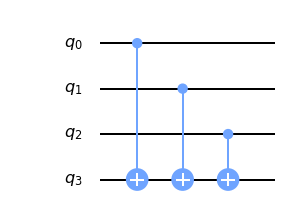

In [2]:
qc=QuantumCircuit(4)

#In this particular oracle, the last qubit is storing the value of the function

qc.cx(0,3)
qc.cx(1,3)
qc.cx(2,3)
#The last qubit is 1 if there are odd no. of 1s in the other 3 qubits
#and 0 otherwise
#Hence it is a balanced function

qc.draw('mpl')

## Example of a quantum circuit for the Deutsch-Josza Algorithm:
Here we will take the simple case wherein the number chosen lies in the range 0 to 3 (i.e. $2^2 - 1$ ) and the function is balanced. The part of the quantum circuit between the barriers is one possible representation of the quantum oracle for this function.

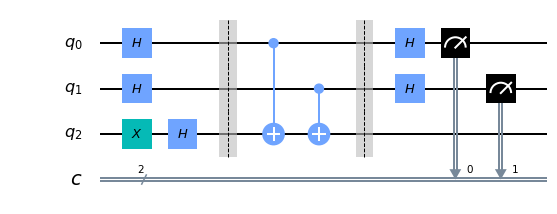

In [3]:
qc1=QuantumCircuit(3)
qc1.x(2)
qc1.h(0)
qc1.h(1)
qc1.h(2)

qc1.barrier(range(3))
qc1.cx(0,2)
qc1.cx(1,2)
qc1.barrier(range(3))
qc1.h(0)
qc1.h(1)

meas = QuantumCircuit(3, 2)
meas.measure(range(2),range(2))

# The Qiskit circuit object supports composition using
# the addition operator.
circ = qc1+meas

circ.draw('mpl')

The following is the result obtained on measuring the query register:

{'11': 1000}


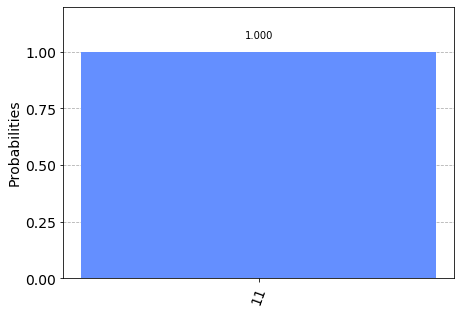

In [4]:
backend_sim = Aer.get_backend('qasm_simulator')

job_sim = execute(circ, backend_sim, shots=1000)

result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
print(counts)
plot_histogram(counts)

Since we do not get an output $\vert 00\rangle$, the function must be balanced.

## Your Task:
**(5 points)**

Your task is to make a quantum circuit (the rest is done for you, you just need to construct the oracle for the below function) for a 4-qubit query resgister. The function is balanced with outputs for each $x$ as given below:

| &nbsp; &nbsp;&nbsp; &nbsp; **$x$ :**  &nbsp;  &nbsp; &nbsp; &nbsp; | &nbsp; &nbsp;&nbsp; &nbsp; **$f(x)$** &nbsp; &nbsp;&nbsp; &nbsp; | &nbsp; &nbsp;&nbsp; &nbsp; **$x$ :**  &nbsp;  &nbsp;&nbsp; &nbsp;| &nbsp; &nbsp;&nbsp; &nbsp; **$f(x)$** &nbsp; &nbsp;&nbsp; &nbsp; |
| :-------------: | :----------: | :-------------------: | :----------: |
| $\vert 0000 \rangle $ | 1 | $\vert 1000 \rangle $ | 0 |
| $\vert 0001 \rangle $ | 0 | $\vert 1001 \rangle $ | 1 |
| $\vert 0010 \rangle $ | 0 | $\vert 1010 \rangle $ | 1 |
| $\vert 0011 \rangle $ | 1 | $\vert 1011 \rangle $ | 0 |
| $\vert 0100 \rangle $ | 0 | $\vert 1100 \rangle $ | 1 |
| $\vert 0101 \rangle $ | 1 | $\vert 1101 \rangle $ | 0 |
| $\vert 0110 \rangle $ | 1 | $\vert 1110 \rangle $ | 0 |
| $\vert 0111 \rangle $ | 0 | $\vert 1111 \rangle $ | 1 |


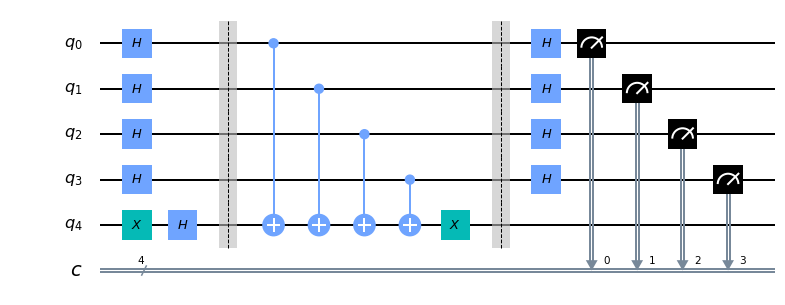

In [16]:
qc2=QuantumCircuit(5)
qc2.x(4)
qc2.h(0)
qc2.h(1)
qc2.h(2)
qc2.h(3)
qc2.h(4)

qc2.barrier(range(5))

qc2.cx(0,4)
qc2.cx(1,4)
qc2.cx(2,4)
qc2.cx(3,4)
qc2.x(4)

qc2.barrier(range(5))
qc2.h(0)
qc2.h(1)
qc2.h(2)
qc2.h(3)

meas2 = QuantumCircuit(5, 4)
meas2.measure(range(4),range(4))

circ2 = qc2+meas2
circ2.draw('mpl')


For demonstrating the values of the function for different inputs, we will use the following circuit. Add and remove $X$ gates as you please, in order to check $f(x)$ for different values of $x$. In this case, $q_4$ will directly give $f(x)$:

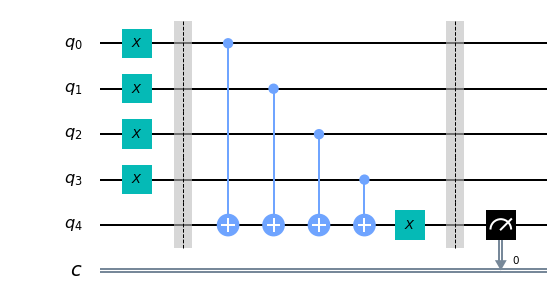

In [49]:
#verification cell, reinitialising the circuit so that it's easier for you to copy-paste the oracle
qc2=QuantumCircuit(5)

qc2.x(3)
qc2.x(2)
qc2.x(1)
qc2.x(0)

qc2.barrier(range(5))

qc2.cx(0,4)
qc2.cx(1,4)
qc2.cx(2,4)
qc2.cx(3,4)
qc2.x(4)

qc2.barrier(range(5))

measv = QuantumCircuit(5, 1)
measv.measure(4,0)

circv = qc2+measv
circv.draw('mpl')

{'1': 1000}


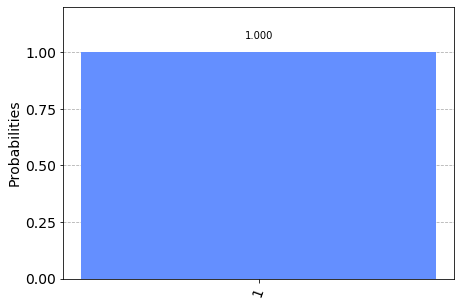

In [50]:
#DO NOT RUN THIS CELL WITHOUT EDITING THE ABOVE ONE AS DESIRED
#The following code will give you f(x) for the value of x you chose in the above cell
backend_sim2 = Aer.get_backend('qasm_simulator')

job_sim2 = execute(circv, backend_sim2, shots=1000)

result_sim2 = job_sim2.result()
counts2 = result_sim2.get_counts(circv)
print(counts2)
plot_histogram(counts2)